## Machine Learning

### Spark Setup

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-37068fa9-9315-4fa2-b9f9-55ccf4e0696d;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 321ms :: artifacts dl 19ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/30 16:24:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/30 16:24:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
3.3.0


In [42]:
bucket = 'dsan-6000-group-35'
submissions = spark.read.parquet(f"s3a://{bucket}/submissions_with_sentiment.parquet")

In [45]:
submissions = submissions.filter(f.col('subreddit')=='TaylorSwift')

In [46]:
submissions.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- score: long (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- sentiment: string (nullable = true)



In [47]:
from pyspark.sql import functions as F
from pyspark.sql.types import BooleanType
def determine_viral(num_comments, num_crossposts, score):
    # Define thresholds for comments, crossposts, and score to consider a post as viral
    comment_threshold = 100  # example threshold
    crosspost_threshold = 10
    score_threshold = 500

    return num_comments > comment_threshold or num_crossposts > crosspost_threshold or score > score_threshold

# Register UDF
is_viral_udf = F.udf(determine_viral, BooleanType())

# Create new column 'is_viral'
submissions = submissions.withColumn("is_viral", is_viral_udf("num_comments", "num_crossposts", "score"))

In [48]:
submissions.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- score: long (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- is_viral: boolean (nullable = true)



In [71]:
submissions = submissions.withColumn("is_self", col("is_self").cast("string"))
submissions = submissions.withColumn("stickied", col("stickied").cast("string"))
submissions = submissions.withColumn("is_viral", col("is_viral").cast("string"))
submissions = submissions.withColumn('text_length',f.length('text'))

In [72]:
stringIndexer_sentiment = StringIndexer(inputCol="sentiment", outputCol="sentiment_idx")
stringIndexer_is_self = StringIndexer(inputCol="is_self", outputCol="is_self_idx")
stringIndexer_stickied = StringIndexer(inputCol="stickied", outputCol="stickied_idx")

# Define OneHotEncoder stages
onehot_sentiment = OneHotEncoder(inputCol="sentiment_idx", outputCol="sentiment_vec")
onehot_is_self = OneHotEncoder(inputCol="is_self_idx", outputCol="is_self_vec")
onehot_stickied = OneHotEncoder(inputCol="stickied_idx", outputCol="stickied_vec")

In [73]:
submissions.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- score: long (nullable = true)
 |-- is_self: string (nullable = true)
 |-- stickied: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- is_viral: string (nullable = true)
 |-- text_length: integer (nullable = true)



In [74]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression

assembler = VectorAssembler(inputCols=["year", "month", "num_comments", "num_crossposts", "score", 
                                       "is_self_vec", "stickied_vec", "sentiment_vec", "text_length"], outputCol="features")

# Define label indexer
labelIndexer = StringIndexer(inputCol="is_viral", outputCol="label")

# Initialize models
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Create pipelines with all stages
pipeline_rf = Pipeline(stages=[stringIndexer_sentiment, stringIndexer_is_self, stringIndexer_stickied,
                               onehot_sentiment, onehot_is_self, onehot_stickied,
                               assembler, labelIndexer, rf])

pipeline_lr = Pipeline(stages=[stringIndexer_sentiment, stringIndexer_is_self, stringIndexer_stickied,
                               onehot_sentiment, onehot_is_self, onehot_stickied,
                               assembler, labelIndexer, lr])

In [75]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data
(train, test) = submissions.randomSplit([0.7, 0.3])

# Fit models
model_rf = pipeline_rf.fit(train)
model_lr = pipeline_lr.fit(train)

# Predict
predictions_rf = model_rf.transform(test)
predictions_lr = model_lr.transform(test)

# Evaluators
evaluator_roc = BinaryClassificationEvaluator(metricName="areaUnderROC")
evaluator_f1 = MulticlassClassificationEvaluator(metricName="f1")

# Evaluate models
roc_rf = evaluator_roc.evaluate(predictions_rf)
roc_lr = evaluator_roc.evaluate(predictions_lr)
f1_rf = evaluator_f1.evaluate(predictions_rf)
f1_lr = evaluator_f1.evaluate(predictions_lr)

# Print results
print(f"Random Forest: ROC AUC = {roc_rf}, F1-score = {f1_rf}")
print(f"Logistic Regression: ROC AUC = {roc_lr}, F1-score = {f1_lr}")


23/11/30 17:19:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/30 17:19:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Random Forest: ROC AUC = 0.9978171301798591, F1-score = 0.9934499160947481
Logistic Regression: ROC AUC = 0.9985071243040634, F1-score = 0.9835852761743906


In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from your provided code
model_names = ["Random Forest", "Logistic Regression"]
roc_values = [roc_rf, roc_lr]
f1_values = [f1_rf, f1_lr]

# Creating the DataFrame for the table
evaluation_table = pd.DataFrame({
    "Model": model_names,
    "ROC AUC": roc_values,
    "F1-score": f1_values
})
evaluation_table

,Model,ROC AUC,F1-score
0,Random Forest,0.997817,0.993450
1,Logistic Regression,0.998507,0.983585


In [80]:
evaluation_table.to_csv('mx109_summary_table.csv')

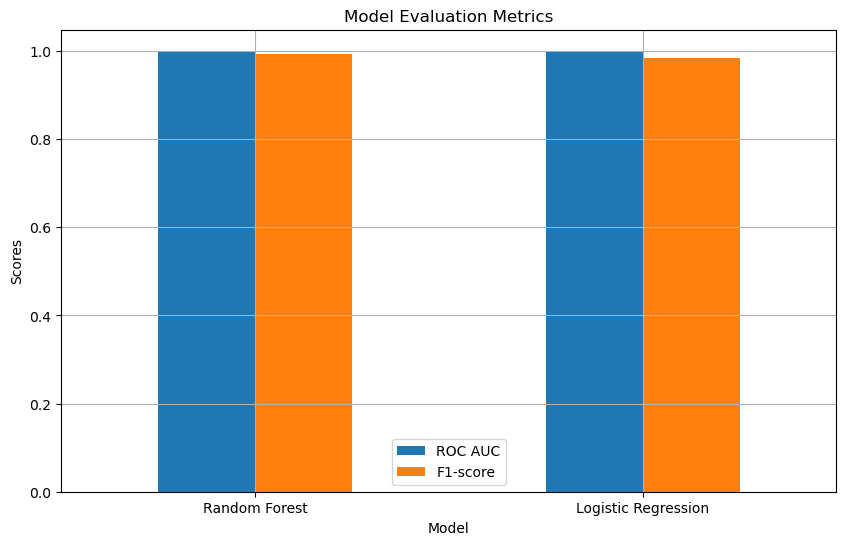

In [81]:


# Creating the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
evaluation_table.plot(kind='bar', x='Model', y=['ROC AUC', 'F1-score'], ax=ax)
plt.title('Model Evaluation Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.grid(True)
plt.savefig('mx109_model_evaluation.png')
# Displaying the table and the chart
plt.show()


## Executive summary

We recently made an effort to examine the popularity of Taylor Swift-related content on Reddit, and the results were impressive. Using advanced machine learning tools, our team is able to decode the elements that help certain posts go viral. The process involves carefully defining what makes a post viral—taking into account number of comments, score, etc.—and using models that can predict which posts are likely to go viral. The results are remarkable. For example, random forest models achieve near-perfect scores on standard evaluation metrics, and logistic regression models are not far behind. This revolutionizes how we plan content, providing a scientific approach to identifying and promoting posts that are likely to be popular on Reddit.

## Analysis report

### Data preparation

The project started by setting up a PySpark environment to efficiently manage large data sets. We selected Taylor Swift-related posts on Reddit and organized the data for better analysis. Important metrics such as number of comments, number of shares, total score, and post length were evaluated. We also take into account factors such as post sentiment. These variables are prepared for the machine learning process through specific techniques such as StringIndexing and OneHotEncoding.

### Model selection and result

We chose two models: random forest and logistic regression because of their ability to handle different types of data. After dividing the data into training and testing parts, we train the model and then evaluate its performance. The evaluation focuses on ROC AUC and F1 score, which are common measures for this type of task. The near-perfect score of the random forest model demonstrates its superior ability to differentiate between viral and non-viral posts. The logistic regression model also showed impressive results, proving its value in predicting viral content.

### Findings

The success of our model demonstrates a strong connection between certain characteristics, such as sentiment and engagement metrics, and the viral potential of a post. This insight is invaluable for posts/authors aiming to go viral on platforms like Reddit.
Visual tools are key to sharing our findings. Graphs showing the most influential features in the random forest model along with the performance curves of the two models help make our complex analysis easy to understand, especially for those unfamiliar with the technical details.

### Conclusion

The project laid the foundation for ongoing analysis. The flexibility of our models means they can be updated with new data, keeping our approach to identifying viral content at the forefront of digital strategy.